Projet d’analyse de sentiment sur Twitter

In [1]:
# Chargement des bibliothèques
# Utilitaires
import re
import time
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Traitement NLP
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Évaluation des modèles
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Chargement du dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=["sentiment", "id", "date", "flag", "user", "text"])


In [3]:
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


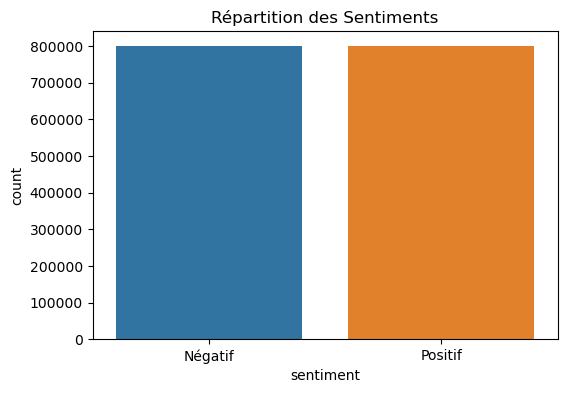

In [5]:
# On garde uniquement les colonnes utiles
df = df[["sentiment", "text"]]

# Remplacement des valeurs (4 = Positif → 1, 0 = Négatif)
df["sentiment"] = df["sentiment"].replace({0: 0, 4: 1})

# Affichage de la distribution des sentiments
plt.figure(figsize=(6,4))
sns.countplot(x=df["sentiment"])
plt.title("Répartition des Sentiments")
plt.xticks(ticks=[0, 1], labels=['Négatif', 'Positif'])
plt.show()

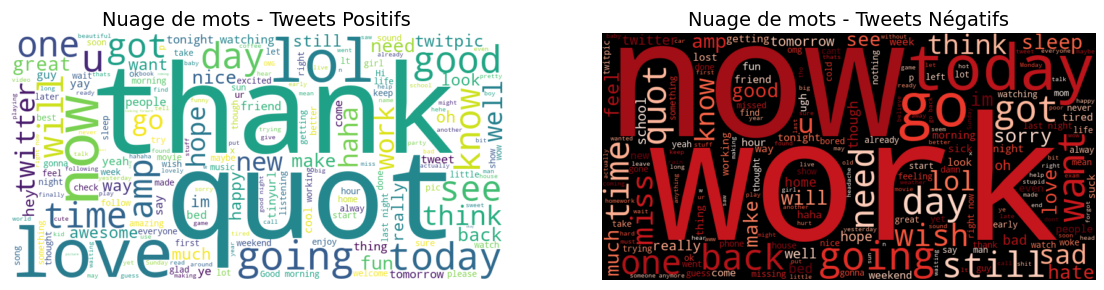

In [6]:
# Visualisation nuage de mots positifs et négatifs
# Séparation des tweets positifs et négatifs
tweets_positifs = " ".join(df[df["sentiment"] == 1]["text"][:100000])  # Limité à 100 000 tweets pour éviter la surcharge
tweets_negatifs = " ".join(df[df["sentiment"] == 0]["text"][:100000])

# Génération des nuages de mots
wordcloud_positif = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(tweets_positifs)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='black', colormap='Reds', max_words=200).generate(tweets_negatifs)

# Affichage des nuages de mots
plt.figure(figsize=(14, 6))

# Nuage de mots positif
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title("Nuage de mots - Tweets Positifs", fontsize=14)
plt.axis("off")

# Nuage de mots négatif
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title("Nuage de mots - Tweets Négatifs", fontsize=14)
plt.axis("off")

# Affichage des résultats
plt.show()

In [7]:
# Définition des Emojis et Stopwords
# Dictionnaire des Emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# # Liste des Stopwords en Anglais
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# Nettoyage du texte
def preprocess(textdata):
    """ Nettoyage et prétraitement des tweets """
    processedText = []
    wordLemm = WordNetLemmatizer()  

    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(r'http\S+|www\S+', 'URL', tweet)  # Suppression des URLs
        tweet = re.sub(r'@[^\s]+', 'UTILISATEUR', tweet)  # Suppression des mentions @
        tweet = re.sub(r'[^a-zA-Z\s]', ' ', tweet)  # Suppression des caractères spéciaux

        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI_" + emojis[emoji])

        mots = ' '.join([wordLemm.lemmatize(mot) for mot in tweet.split() if mot not in stopwords])
        processedText.append(mots)

    return processedText

# Application du nettoyage
t = time.time()
df["text"] = preprocess(df["text"].tolist())  
print(f'Traitement du texte terminé en {round(time.time()-t)} secondes')

Traitement du texte terminé en 115 secondes


In [11]:
df.head()

,sentiment,text
0,0,UTILISATEUR URL aURL bummer shoulda got david ...
1,0,upset update facebook texting might cry result...
2,0,UTILISATEUR dived many time ball managed save ...
3,0,whole body feel itchy like fire
4,0,UTILISATEUR no not behaving mad see over


In [12]:
# Fonction d'affichage de la matrice de confusion
def afficher_matrice_confusion(cm, titre):
    """Affiche une matrice de confusion"""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
    plt.title(titre)
    plt.ylabel("Valeurs Réelles")
    plt.xlabel("Valeurs Prédites")
    plt.show()

In [13]:
# Fonction d'entraînement et d'évaluation des modèles
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

def entrainer_et_evaluer(sample_size):
    """Entraîne et teste les modèles sur un échantillon donné avec affichage des matrices de confusion"""
    
    print(f"\n### Entraînement sur un échantillon de {sample_size} tweets ###")
    
    # Sélection des tweets
    df_sample = df.sample(n=sample_size, random_state=42)
    
    X_sample = df_sample["text"]
    y_sample = df_sample["sentiment"]
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
    
    # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    modeles = {
        "Bernoulli Naive Bayes": BernoulliNB(),
        "Support Vector Classifier": LinearSVC(),
        "Régression Logistique": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    for nom, modele in modeles.items():
        print(f"\n*** {nom} - Échantillon {sample_size} ***")
        
        modele.fit(X_train_tfidf, y_train)
        y_pred = modele.predict(X_test_tfidf)

        print(f"Précision : {accuracy_score(y_test, y_pred):.4f}")
        print(f"Rapport de classification :\n{classification_report(y_test, y_pred)}")

        # Affichage de la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        afficher_matrice_confusion(cm, f"Matrice de Confusion - {nom} (Échantillon {sample_size})")



### Entraînement sur un échantillon de 800000 tweets ###

*** Bernoulli Naive Bayes - Échantillon 800000 ***
Précision : 0.7646
Rapport de classification :
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     79976
           1       0.76      0.77      0.77     80024

    accuracy                           0.76    160000
   macro avg       0.76      0.76      0.76    160000
weighted avg       0.76      0.76      0.76    160000



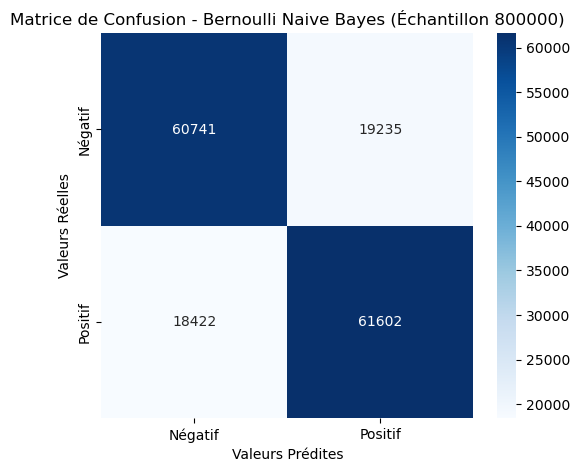


*** Support Vector Classifier - Échantillon 800000 ***


c:\Users\micht\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Précision : 0.7668
Rapport de classification :
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     79976
           1       0.76      0.78      0.77     80024

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



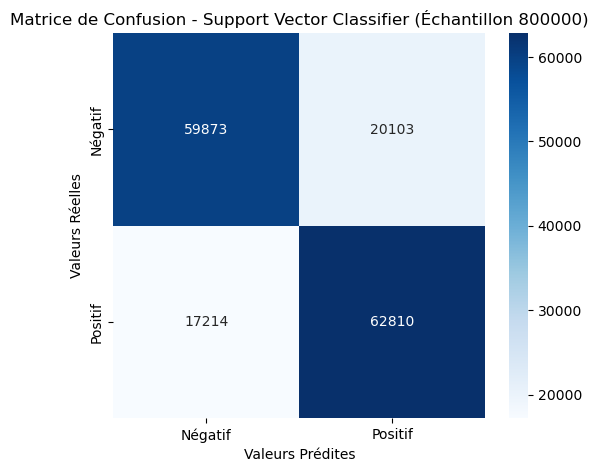


*** Régression Logistique - Échantillon 800000 ***


c:\Users\micht\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Précision : 0.7748
Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.76      0.77     79976
           1       0.76      0.79      0.78     80024

    accuracy                           0.77    160000
   macro avg       0.78      0.77      0.77    160000
weighted avg       0.78      0.77      0.77    160000



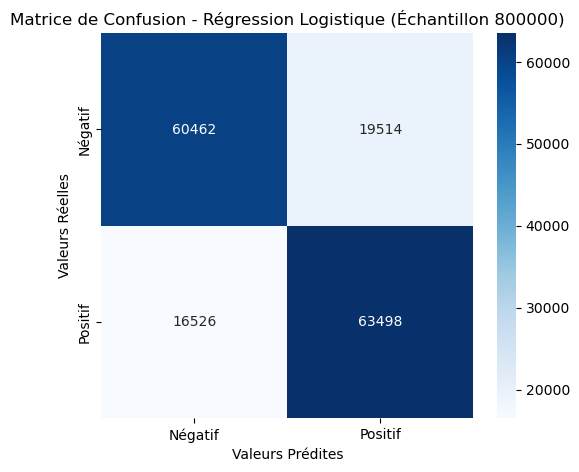


*** Random Forest - Échantillon 800000 ***
Précision : 0.6983
Rapport de classification :
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     79976
           1       0.70      0.69      0.70     80024

    accuracy                           0.70    160000
   macro avg       0.70      0.70      0.70    160000
weighted avg       0.70      0.70      0.70    160000



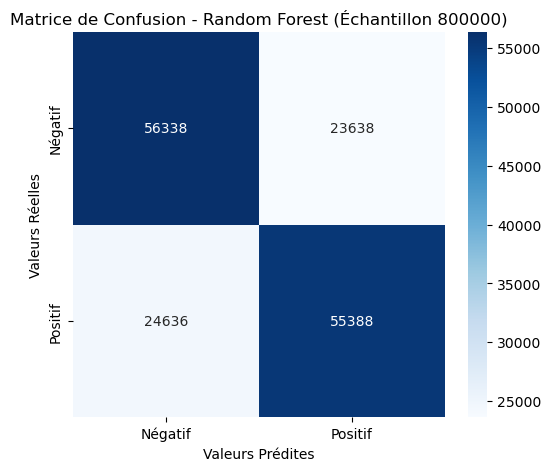


*** XGBoost - Échantillon 800000 ***


c:\Users\micht\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision : 0.7325
Rapport de classification :
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     79976
           1       0.73      0.74      0.73     80024

    accuracy                           0.73    160000
   macro avg       0.73      0.73      0.73    160000
weighted avg       0.73      0.73      0.73    160000



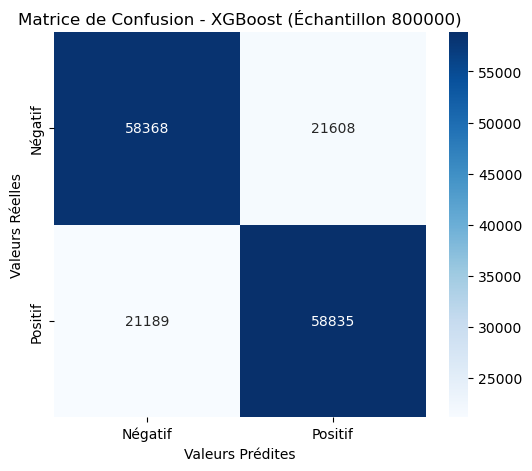

In [14]:
# Test avec 800 000 tweets
entrainer_et_evaluer(800000)


### Entraînement sur un échantillon de 900000 tweets ###

*** Bernoulli Naive Bayes - Échantillon 900000 ***
Précision : 0.7642
Rapport de classification :
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     89991
           1       0.76      0.77      0.77     90009

    accuracy                           0.76    180000
   macro avg       0.76      0.76      0.76    180000
weighted avg       0.76      0.76      0.76    180000



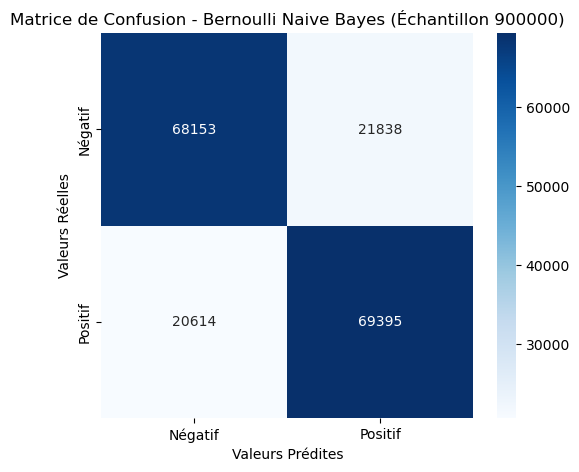


*** Support Vector Classifier - Échantillon 900000 ***


c:\Users\micht\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Précision : 0.7675
Rapport de classification :
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     89991
           1       0.76      0.79      0.77     90009

    accuracy                           0.77    180000
   macro avg       0.77      0.77      0.77    180000
weighted avg       0.77      0.77      0.77    180000



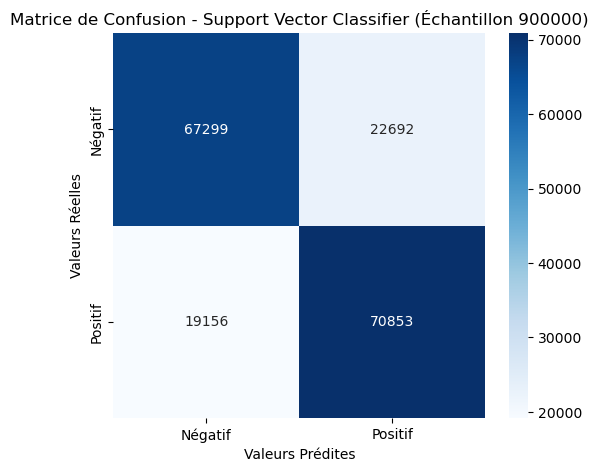


*** Régression Logistique - Échantillon 900000 ***


c:\Users\micht\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Précision : 0.7745
Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     89991
           1       0.76      0.80      0.78     90009

    accuracy                           0.77    180000
   macro avg       0.77      0.77      0.77    180000
weighted avg       0.77      0.77      0.77    180000



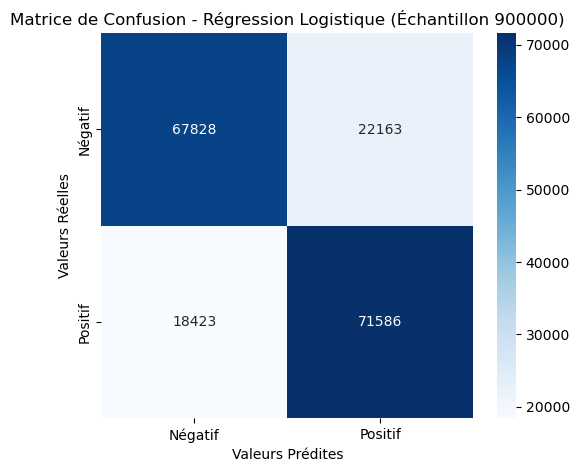


*** Random Forest - Échantillon 900000 ***
Précision : 0.6685
Rapport de classification :
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     89991
           1       0.67      0.67      0.67     90009

    accuracy                           0.67    180000
   macro avg       0.67      0.67      0.67    180000
weighted avg       0.67      0.67      0.67    180000



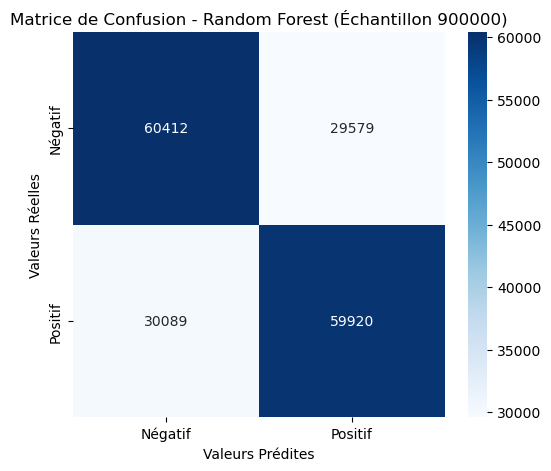


*** XGBoost - Échantillon 900000 ***


c:\Users\micht\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision : 0.7323
Rapport de classification :
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     89991
           1       0.73      0.74      0.73     90009

    accuracy                           0.73    180000
   macro avg       0.73      0.73      0.73    180000
weighted avg       0.73      0.73      0.73    180000



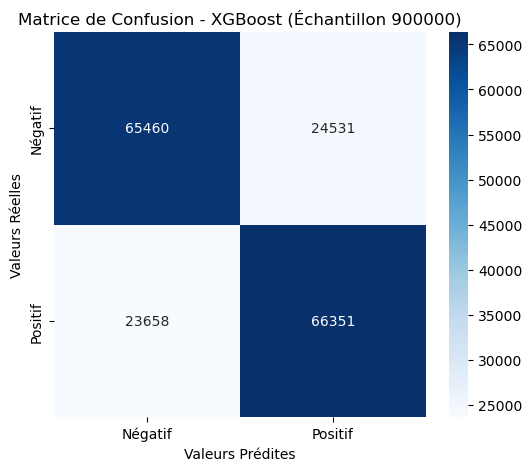

In [15]:
# Test avec 900 000 tweets
entrainer_et_evaluer(900000)


### Entraînement sur un échantillon de 1000000 tweets ###

*** Bernoulli Naive Bayes - Échantillon 1000000 ***
Précision : 0.7641
Rapport de classification :
              precision    recall  f1-score   support

           0       0.77      0.76      0.76    100199
           1       0.76      0.77      0.77     99801

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



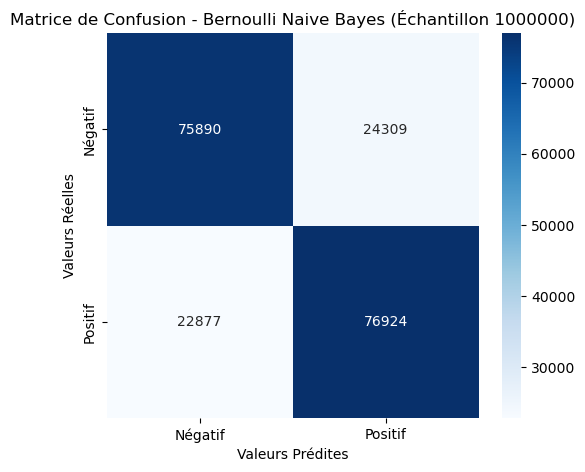


*** Support Vector Classifier - Échantillon 1000000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Précision : 0.7687
Rapport de classification :
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    100199
           1       0.76      0.79      0.77     99801

    accuracy                           0.77    200000
   macro avg       0.77      0.77      0.77    200000
weighted avg       0.77      0.77      0.77    200000



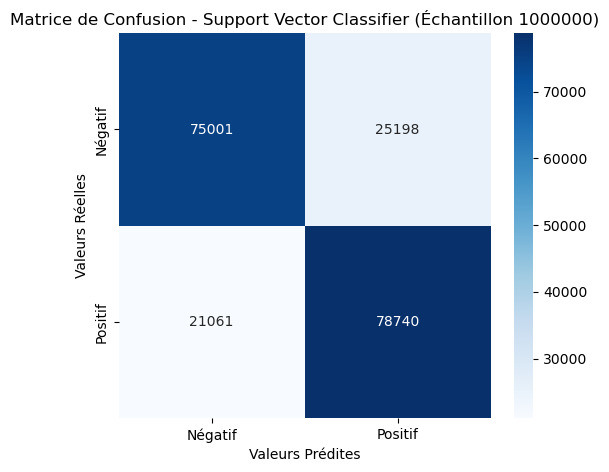


*** Régression Logistique - Échantillon 1000000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Précision : 0.7745
Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    100199
           1       0.76      0.80      0.78     99801

    accuracy                           0.77    200000
   macro avg       0.78      0.77      0.77    200000
weighted avg       0.78      0.77      0.77    200000



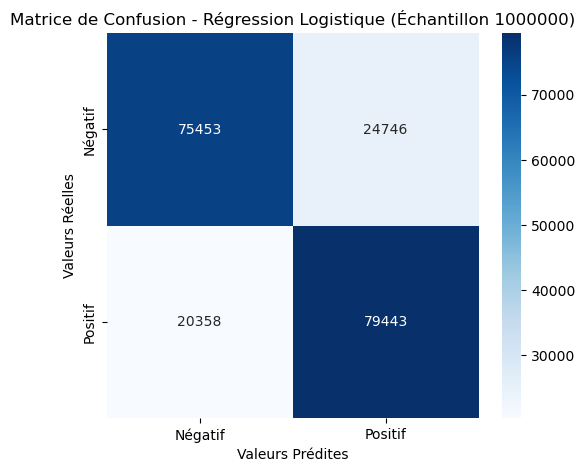


*** Random Forest - Échantillon 1000000 ***
Précision : 0.7031
Rapport de classification :
              precision    recall  f1-score   support

           0       0.76      0.59      0.67    100199
           1       0.66      0.82      0.73     99801

    accuracy                           0.70    200000
   macro avg       0.71      0.70      0.70    200000
weighted avg       0.71      0.70      0.70    200000



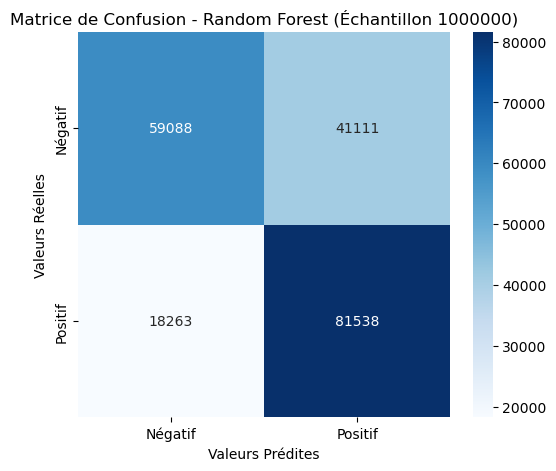


*** XGBoost - Échantillon 1000000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision : 0.7318
Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.72      0.73    100199
           1       0.73      0.74      0.73     99801

    accuracy                           0.73    200000
   macro avg       0.73      0.73      0.73    200000
weighted avg       0.73      0.73      0.73    200000



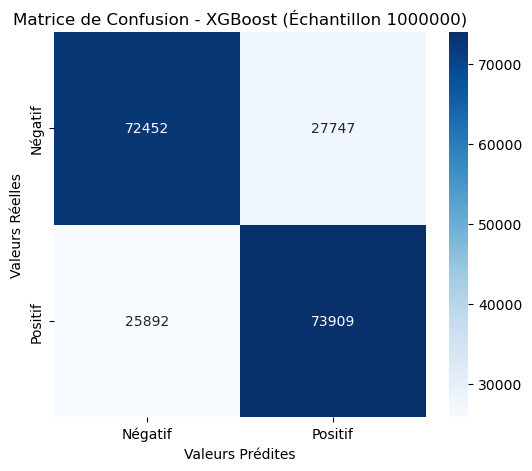

In [13]:
# Test avec 1 000 000 tweets
entrainer_et_evaluer(1000000)


### Entraînement sur un échantillon de 1600000 tweets ###

*** Bernoulli Naive Bayes - Échantillon 1600000 ***
Précision : 0.7664
Rapport de classification :
              precision    recall  f1-score   support

           0       0.77      0.76      0.76    159989
           1       0.76      0.77      0.77    160011

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



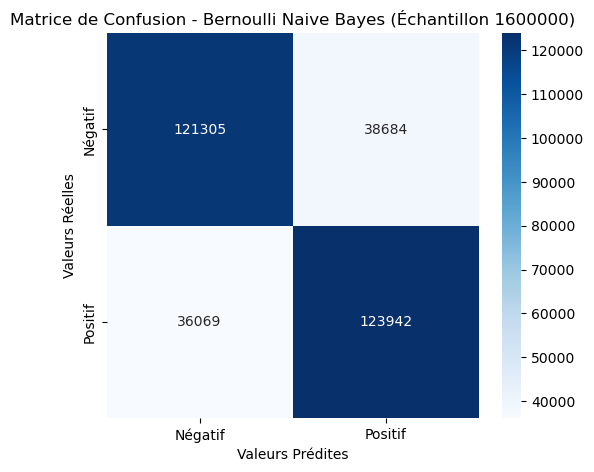


*** Support Vector Classifier - Échantillon 1600000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Précision : 0.7714
Rapport de classification :
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159989
           1       0.76      0.79      0.78    160011

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



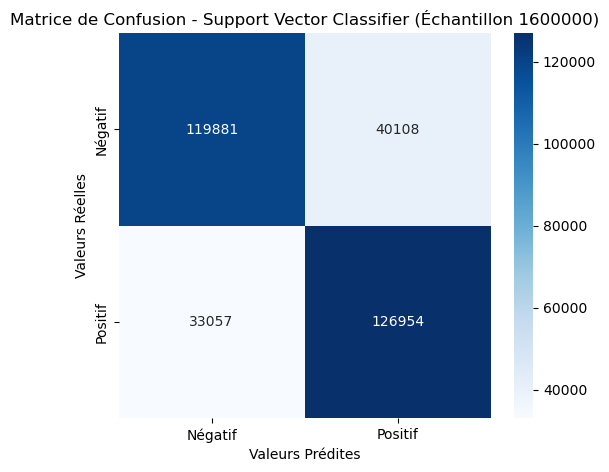


*** Régression Logistique - Échantillon 1600000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Précision : 0.7762
Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159989
           1       0.77      0.80      0.78    160011

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



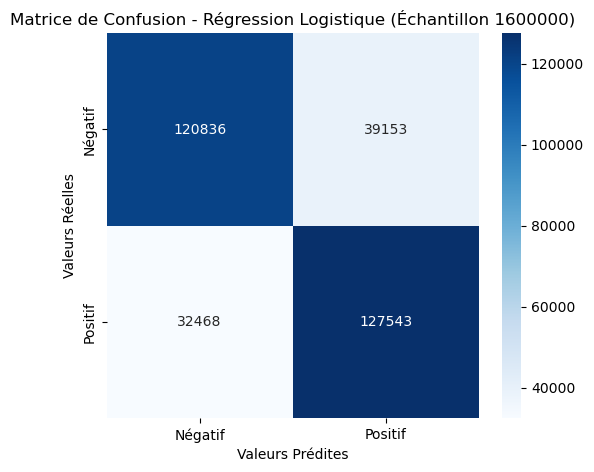


*** Random Forest - Échantillon 1600000 ***
Précision : 0.7104
Rapport de classification :
              precision    recall  f1-score   support

           0       0.75      0.62      0.68    159989
           1       0.68      0.80      0.73    160011

    accuracy                           0.71    320000
   macro avg       0.72      0.71      0.71    320000
weighted avg       0.72      0.71      0.71    320000



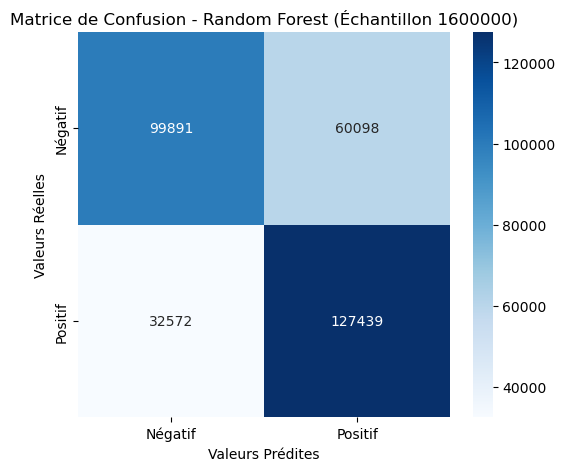


*** XGBoost - Échantillon 1600000 ***


c:\Users\jalak\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision : 0.7334
Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.73      0.73    159989
           1       0.73      0.74      0.74    160011

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



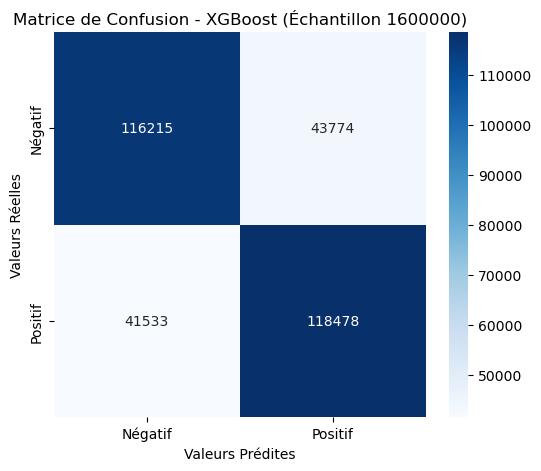

In [14]:
# Test avec 1 600 000 tweets
entrainer_et_evaluer(1600000)